In [1]:
%%capture
!uv pip install s3fs zarr ctime fsspec

*Workshop 4. Doing research with hydrological data*


# Practical 1: Compare rainfall estimates from different sources


## Learning objectives:
- Learn how to format rainfall data from different sources
- Compute simple statistics to compare rainfall estimates between gridded rainfall and rain gauge data 


# Introduction
Rainfall is notoriously difficult to measure accurately, but in the UK we have a dense network of both [rain gauges](https://en.wikipedia.org/wiki/Rain_gauge) and [rain radar](https://en.wikipedia.org/wiki/Weather_radar) stations (**Figure 1**). These network gives us a relatively reliable and consistent estimate of rainfall through time, even when there is missing or wrong data, because estimates are cross-checked agaisnt other nearby measurements. 

![Map of UK rain gauge stations](../content/Maps-of-daily-rain-gauges-used-to-derive-the-CEH-GEAR-data-set-a-monthly-rain-gauges.png)  
*Figure 1. Maps of daily rain gauges in 2012: (a) monthly rain gauges and (b) daily rain gauges (source: Keller et al. 2015).*


The UKCEH is also working-on a updated interactive map of the UK's rain gauge network (as of 2025), which you can find a version of [here](https://thomasjkeel.github.io/UK-Rain-Gauge-Network/gauges.html).

## Gridded rainfall data
> *Gridded rainfall products provide a spatially- and temporally-uniform estimate of rainfall*

Whilst, the UK's rain gauge network provides valuable data, its coverage is both spatially and temporally uneven. Some areas—such as Scotland—have a much denser concentration of gauges than others, like the South of England. Additionally, the gauges themselves vary in age and data quality.  

As such, it can be inconvenient to work with rain gauge data. For this reason, environmental researchers often prefer datasets that are interpolated onto regular grids, which are easier to process, analyze, and compare over space and time.


For the UK, two main gridded rainfall products exist:  
1. CEH-GEAR — provides daily/monthly 1km gridded rainfall, produced by the UKCEH and described in [Keller et al. 2015](https://essd.copernicus.org/articles/7/143/2015/)
2. HadUK-Grid — provides daily/monthly/seasonal/annual 1km gridded rainfall, produced by the Met Office and described in [Hollis et al. 2019](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/gdj3.78)

Each product provides slightly different methodology for spatially interpolating data from the UK rain gauge network to a regular 1km grid, shown diagramatically in Figure 2 (see more in those papers if you are interested in the specifics). For this practical, we will be using the CEH-GEAR dataset, but for future, you can access the HadUK-Grid [here](https://catalogue.ceda.ac.uk/uuid/4dc8450d889a491ebb20e724debe2dfb/)).


![example of gridding](../content/gridding_example_from_gdal.png)  
*Figure 2. Diagram showing example of interpolation of points to regular grid (source: GDAL 2025).*





In [2]:
# Load required libraries
import fsspec
import zarr

import geopandas as gpd
import polars as pl
import xarray as xr

import rioxarray

import matplotlib.pyplot as plt
import seaborn as sns

# practical-specific file:
import data_utils

In [3]:
# Global variables for coordinates of Severn River catchment
SEVERN_NORTHING_RANGE = [270000, 349000]
SEVERN_EASTING_RANGE = [280000, 390000]

# 1. Load rainfall data
First we will read in gridded rainfall and rain gauge data using code shown in Workshop 2.

**External data sources:**
- UK-wide CEH-GEAR rainfall data - from the JASMIN object-store
- Rain gauge data for the Severn River Catchment - from the JASMIN object-store
- Severn catchment boundaries - from the National River Flow Archive ([NRFA](https://nrfa.ceh.ac.uk/data/search))
- River Severn watercourse - from [OS Open Rivers](https://www.ordnancesurvey.co.uk/products/os-open-rivers)

## 1.1 Load CEH-GEAR (gridded rainfall data)
Using the code from Workshop 2, below we connect to the S3 bucket on the JASMIN object-store (remote) and load in a local version of the daily CEH-GEAR file ("geardaily_fulloutput_yearly_100km_chunks.zarr")

In [4]:
fdri_fs = fsspec.filesystem(
    "s3", asynchronous=True, anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk"
)
gear_daily_zstore = zarr.storage.FsspecStore(
    fdri_fs, path="geardaily/GB/geardaily_fulloutput_yearly_100km_chunks.zarr"
)
gear_daily = xr.open_zarr(gear_daily_zstore, decode_times=True, decode_cf=True)
gear_daily  # 310 GB worth of data

<xarray.Dataset> Size: 666GB
Dimensions:          (y: 1251, x: 701, time: 47481)
Coordinates:
    crs              int16 2B ...
    lat              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 6kB 0.0 1e+03 2e+03 ... 6.98e+05 6.99e+05 7e+05
  * y                (y) float64 10kB 1.25e+06 1.249e+06 1.248e+06 ... 1e+03 0.0
Data variables:
    min_dist         (time, y, x) float64 333GB dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 333GB dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In these practicals, there will be questions, please fill them in the best you can before moving on (or ask us for help)
#### ❓ Question: what type of file is the input data?
Replace the ??? in this markdown box with your answer 
(*hint: check the file extension*)

**Answer:** ???

#### ❓ Question: what data type is the 'gear_daily' data we have loaded in?

Replace the ??? in the code-block below with your answer

In [5]:
type(???)

SyntaxError: invalid syntax (3631905147.py, line 1)

Let's have a quick look at one day in the CEH-GEAR dataset...

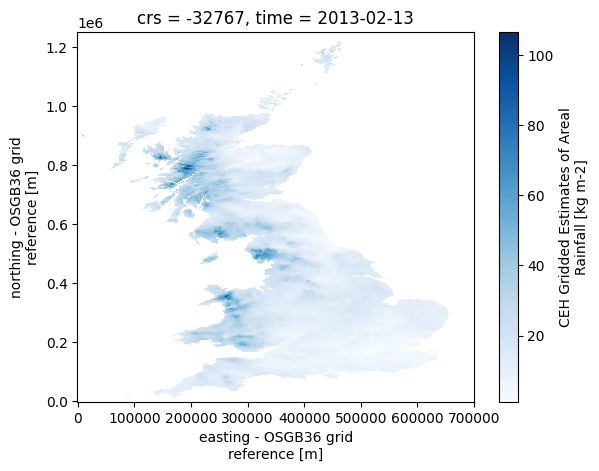

In [5]:
# plot data
fig, ax = plt.subplots(1)
gear_daily.sel(time="2013-02-13")["rainfall_amount"].plot(ax=ax, cmap="Blues")

## 1.2 Load daily rain gauge data
Next, we will load daily rain gauge data and it's associated metadata from the JASMIN object-store.

🐻‍❄️ **Note:** we use the [polars](https://pola.rs/) instead of pandas to load data, but its syntax should be relatively familiar.

In [6]:
severn_rain_gauge_data = pl.read_csv(
    "s3://rain-gauge/hourly_severn_rain_gauge_data.csv",
    storage_options={"endpoint_url": "https://fdri-o.s3-ext.jc.rl.ac.uk", "anon": True},
    try_parse_dates=True,
)
severn_rain_gauge_metadata = pl.read_csv(
    "s3://rain-gauge/hourly_severn_rain_gauge_metadata.csv",
    storage_options={"endpoint_url": "https://fdri-o.s3-ext.jc.rl.ac.uk", "anon": True},
)

In [7]:
severn_rain_gauge_data.head()

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
89714,1978-10-01 00:00:00,0.0
89714,1978-10-02 00:00:00,2.0
89714,1978-10-03 00:00:00,0.0
89714,1978-10-04 00:00:00,0.0
89714,1978-10-05 00:00:00,0.0


In [8]:
severn_rain_gauge_metadata.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
89714,2913,"""STRONGFORD W WKS""","""GB-GBN""",387932,339157,28,95,"""/BI/UK/GB/ENG/STS/"""
90358,2918,"""SUGNALL HALL""","""GB-GBN""",379831,331185,28,143,"""/BI/UK/GB/ENG/STS/"""
90359,2919,"""ECCLESHALL, SUGNALL HALL""","""GB-GBN""",379800,331200,28,137,"""/BI/UK/GB/ENG/STS/"""
90492,2920,"""WALTON HALL GARDENS""","""GB-GBN""",384900,328500,28,99,"""/BI/UK/GB/ENG/STS/"""
90537,2921,"""WHITMORE P STA""","""GB-GBN""",379900,340100,28,121,"""/BI/UK/GB/ENG/CHS/"""


#### ❓ Question: what type of file is the input data?

Replace the ??? in this markdown box with your answer

**Answer:** ???

#### ❓ Question: what data type is the 'severn_rain_gauge_data'?

Replace the ??? in the code-block below with your answer

In [ ]:
???

Let's subset the data to look at precipitation from a single rain gauge...

In [9]:
severn_rain_gauge_data.filter(pl.col("ID") == 90537)

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
90537,1961-01-01 00:00:00,2.0
90537,1961-01-02 00:00:00,5.1
90537,1961-01-03 00:00:00,1.5
90537,1961-01-04 00:00:00,0.0
90537,1961-01-05 00:00:00,10.9
…,…,…
90537,1989-03-27 00:00:00,7.3
90537,1989-03-28 00:00:00,0.1
90537,1989-03-29 00:00:00,0.0


🐼: above code is equivalent to: `severn_rain_gauge_data.loc[severn_rain_gauge_data["ID"] == 90537]`

#### 🤨 Task: Subset the precipitation data to the station: "WALFORD" 

Replace the ??? below with your answer

*Hint: you can use the `.filter` method like above*

In [46]:
# Step 1. Find the "ID" for the station with the name: "WALFORD" in the metadata
severn_rain_gauge_metadata.???

In [ ]:
# Step 2. Using that ID, subset the rain gauge data
severn_rain_gauge_data.???

## 1.3 Load spatial datasets for Upper Severn catchment
Finally, we download some spatial data for the River Severn, including catchment boundaries from the NRFA, and watercourse data from Ordinance Survey.

Data originally downloaded from: [NRFA](https://nrfa.ceh.ac.uk/data/search) & [Ordinance Survey](https://www.ordnancesurvey.co.uk/products/os-open-rivers)

This bash script below will fetch and download spatial data from GitHub and store it locally in the folder 'severn_catchment_data'

In [10]:
%%capture
# !wget -O https://github.com/Thomasjkeel/UKCEH_Summer_School_2025/blob/edit/workshop-3/Workshop_4/severn_catchment_data.tar.gz
!mkdir -p severn_catchment_data
!tar -xvf severn_catchment_data.tar.gz -C severn_catchment_data

Load shapefiles & geojson using geopandas

In [11]:
# Greater Severn catchment boundary
bewdley_shp = gpd.read_file("severn_catchment_data/Bewdley/54001/54001.shp")

# Upper Severn catchment boundaries
abermule_shp = gpd.read_file("severn_catchment_data/Abermule/54014/54014.shp")
dolwen_shp = gpd.read_file("severn_catchment_data/Dolwen/54080/54080.shp")
plynlimon_shp = gpd.read_file("severn_catchment_data/Plynlimon Flume/54022/54022.shp")

In [12]:
# Load rivers linestrings
severn_catchment_river_linestrings = gpd.read_file(
    "severn_catchment_data/rivers_around_severn.geojson"
)
severn_river_linestrings = severn_catchment_river_linestrings.loc[
    severn_catchment_river_linestrings["name1"].str.contains("River Severn")
]

Next, we plot the catchment boundaries and the River Severn

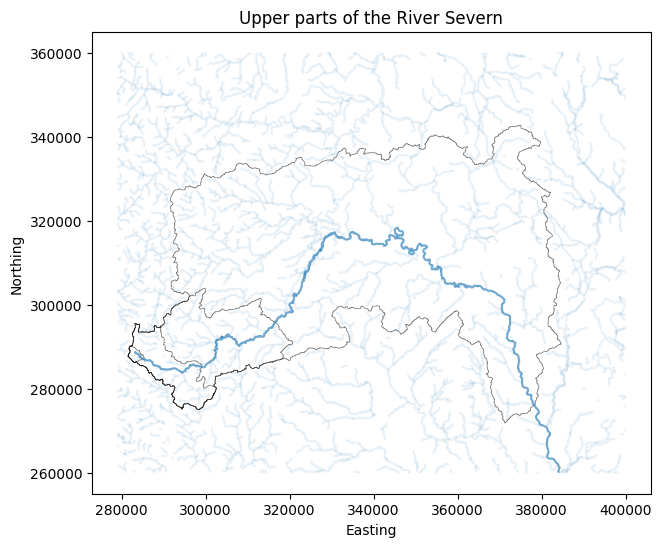

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
abermule_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)
bewdley_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)
dolwen_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)
plynlimon_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)

severn_catchment_river_linestrings.plot(ax=ax, alpha=0.1)
severn_river_linestrings.plot(ax=ax, alpha=0.6)
ax.set_title("Upper parts of the River Severn")
plt.subplots_adjust(hspace=0.2)

We'll also load in some height data 

In [14]:
severn_hght = rioxarray.open_rasterio("severn_catchment_data/HGHT_SEVERN_1KM_CLIP.tif")
severn_hght = severn_hght.sortby("y")
severn_hght = severn_hght.sel(band=1)
severn_hght = severn_hght / 10  # divide by 10, so in metres
severn_hght = severn_hght.sel(
    x=slice(*SEVERN_EASTING_RANGE), y=slice(*SEVERN_NORTHING_RANGE)
)

Text(0.5, 1.0, 'Height profile of upper parts of the River Severn')

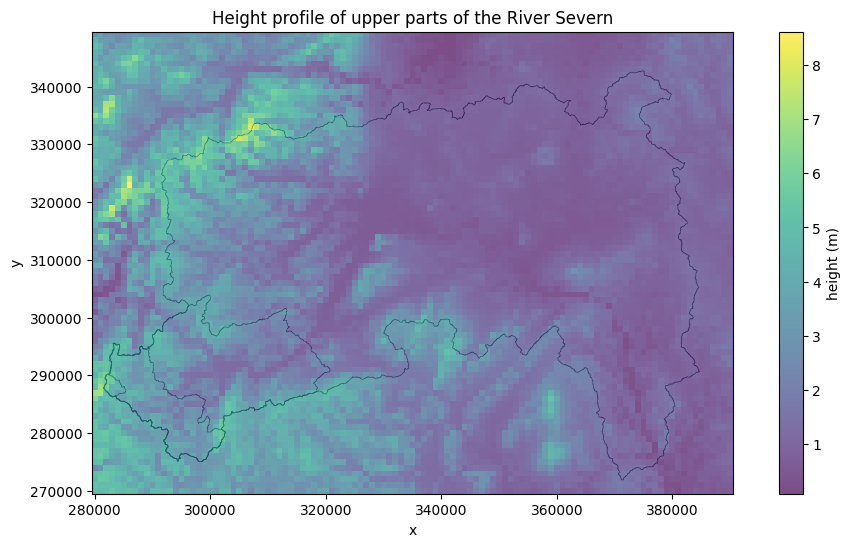

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
abermule_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
bewdley_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
dolwen_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
plynlimon_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
severn_hght.plot(ax=ax, alpha=0.7, cbar_kwargs={"label": "height (m)"})

ax.set_title("Height profile of upper parts of the River Severn")

# 2. Format the data
Most of data science is about data cleaning and formatting. This is especially true for those using environmental data, where we often have datasets from many different sources, and that are of varying quality.

In this section, we will prepare the datasets, so we can compare the rain gauge dataset to gridded rainfall in the next section.


## 2.1 Checking for gaps in data
There are many issues with the rainfall dataset we are using because it has not been quality controlled. This includes gaps, streaks of repeating values, exceedances of world records, misinputted data, etc.. However, in the interest of moving swiftly on, we will only focus on finding gaps. To do this we calculate a data 'completeness' for each gauge comparing number of rows to expected number of rows.

>*Note:* if you are interested in quality controlling rain gauge data, see the Python package [RainfallQC](https://github.com/NERC-CEH/RainfallQC) and find some examples [here](https://github.com/Thomasjkeel/RainfallQC-notebooks))


In [16]:
# To save RAM later on, we'll filter out rows before 1950
severn_rain_gauge_data = severn_rain_gauge_data.filter(pl.col("DATETIME") > pl.date(year=1950, month=1, day=1))

In [17]:
# load in a single gappy gauge
one_gauge = severn_rain_gauge_data.filter(pl.col("ID") == 90806) 

<Axes: xlabel='DATETIME'>

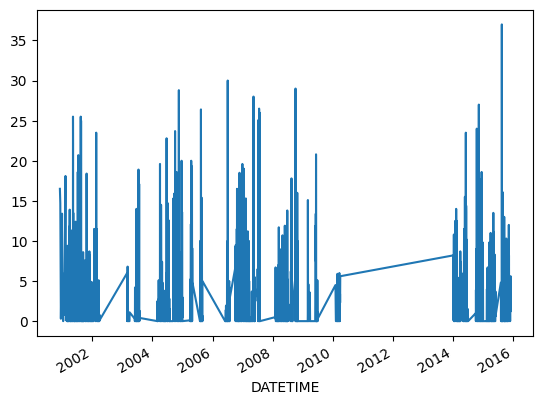

In [18]:
# plot data to see gaps
one_gauge.to_pandas().set_index("DATETIME")["PRECIPITATION"].plot() # here we convert polars to pandas to let us plot longer time series

In the above plot, clearly there are some gaps in the data. We do not want to include this in our final clean dataset.  

Let's create a completeness metric, by comparing the start and end dates of each gauge, and then checking how many data rows are missing

In [19]:
# Compute observed days between start and end date
severn_rain_gauge_data_observed = severn_rain_gauge_data.group_by("ID").agg(
    [
        pl.col("DATETIME").min().alias("start_date"),
        pl.col("DATETIME").max().alias("end_date"),
        pl.len().alias("observed_days"),
    ]
)
severn_rain_gauge_data_observed.head()

ID,start_date,end_date,observed_days
i64,datetime[μs],datetime[μs],u32
423008,1983-11-01 00:00:00,2005-02-28 00:00:00,7516
424053,1961-01-01 00:00:00,1983-08-31 00:00:00,8278
425345,1976-01-01 00:00:00,1998-12-28 00:00:00,6320
90805,2007-03-01 00:00:00,2024-12-31 00:00:00,6485
426762,1980-01-01 00:00:00,2001-02-28 00:00:00,7699


In [20]:
# Compute expected days between start and end date
severn_rain_gauge_data_observed_and_expected = (
    severn_rain_gauge_data_observed.with_columns(
        [
            ((pl.col("end_date") - pl.col("start_date")).dt.total_days() + 1).alias(
                "expected_days"
            ),
        ]
    )
)

severn_rain_gauge_data_observed_and_expected.head()

ID,start_date,end_date,observed_days,expected_days
i64,datetime[μs],datetime[μs],u32,i64
423008,1983-11-01 00:00:00,2005-02-28 00:00:00,7516,7791
424053,1961-01-01 00:00:00,1983-08-31 00:00:00,8278,8278
425345,1976-01-01 00:00:00,1998-12-28 00:00:00,6320,8398
90805,2007-03-01 00:00:00,2024-12-31 00:00:00,6485,6516
426762,1980-01-01 00:00:00,2001-02-28 00:00:00,7699,7730


In [21]:
# Divide observed by expected and get percentage completeness
severn_rain_gauge_data_completeness = (
    severn_rain_gauge_data_observed_and_expected.with_columns(
        [
            ((pl.col("observed_days") / pl.col("expected_days")) * 100).alias(
                "perc_completeness"
            )
        ]
    )
)

severn_rain_gauge_data_completeness.head()

ID,start_date,end_date,observed_days,expected_days,perc_completeness
i64,datetime[μs],datetime[μs],u32,i64,f64
423008,1983-11-01 00:00:00,2005-02-28 00:00:00,7516,7791,96.470286
424053,1961-01-01 00:00:00,1983-08-31 00:00:00,8278,8278,100.0
425345,1976-01-01 00:00:00,1998-12-28 00:00:00,6320,8398,75.256013
90805,2007-03-01 00:00:00,2024-12-31 00:00:00,6485,6516,99.524248
426762,1980-01-01 00:00:00,2001-02-28 00:00:00,7699,7730,99.598965


Some of the rain gauges are particularly gappy

In [22]:
severn_rain_gauge_data_completeness.filter(pl.col("perc_completeness") < 60)

ID,start_date,end_date,observed_days,expected_days,perc_completeness
i64,datetime[μs],datetime[μs],u32,i64,f64
425005,1988-11-01 00:00:00,1989-06-30 00:00:00,91,242,37.603306
425940,1962-02-01 00:00:00,1966-03-31 00:00:00,729,1520,47.960526
427589,1972-08-01 00:00:00,1983-02-28 00:00:00,2249,3864,58.203934
429827,1995-01-01 00:00:00,1996-05-31 00:00:00,212,517,41.005803
422169,1961-01-01 00:00:00,1975-12-31 00:00:00,3283,5478,59.930632
422661,1968-01-01 00:00:00,1971-06-30 00:00:00,213,1277,16.679718
90806,2000-12-05 00:00:00,2015-11-30 00:00:00,1989,5474,36.335404


### 🤨 Task: Filter out data with less than 90% completeness
Let's create a dataset that is more reliable

Replace the ??? below with your answer

*Hint: remember to break down the problem into steps, and print things out if unsure*

In [23]:
# Step 1. Get the IDs of gauges above 90% threshold
reliable_gauge_ids = severn_rain_gauge_data_completeness.filter(
    pl.col(???) > ???
)["ID"].to_list()

In [24]:
# filter data to include only those ID's with more than 90% completeness
severn_rain_gauge_data_filtered = severn_rain_gauge_data.???(
    pl.col("ID").is_in(???)
)

#### 🤨 Optional task: Take a look at the gauge 428554, what other issues can you see?:


# 2.2 Subset spatial data

We have data for the entire UK, let's subset our data into the areas around the River Severn only and for data since 1950

In [25]:
severn_gear_daily = gear_daily.sel(
    x=slice(*SEVERN_EASTING_RANGE),
    y=slice(*sorted(SEVERN_NORTHING_RANGE, reverse=True)), # has to be reversed as y coordinates is descending
    time=slice("1950", None)    
)
severn_gear_daily = severn_gear_daily.drop_vars("min_dist") # drop unecessary variable
severn_gear_daily = severn_gear_daily.sortby("y")  # flip y coordinates

In [26]:
%%time
# Load data into RAM (memory)
# this code-block takes about 90 seconds
severn_gear_daily.load()

CPU times: user 12.6 s, sys: 17.7 s, total: 30.3 s
Wall time: 1min 5s


<xarray.Dataset> Size: 2GB
Dimensions:          (y: 80, x: 111, time: 25567)
Coordinates:
    crs              int16 2B -32767
    lat              (y, x) float64 71kB 9.969e+36 9.969e+36 ... 9.969e+36
    lon              (y, x) float64 71kB 9.969e+36 9.969e+36 ... 9.969e+36
  * time             (time) datetime64[ns] 205kB 1950-01-01 ... 2019-12-31
  * x                (x) float64 888B 2.8e+05 2.81e+05 ... 3.89e+05 3.9e+05
  * y                (y) float64 640B 2.7e+05 2.71e+05 ... 3.48e+05 3.49e+05
Data variables:
    rainfall_amount  (time, y, x) float64 2GB 2.4 2.397 2.497 ... 0.0 0.0 0.0
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

You can also see the spatial profile of the rain gauge data in the below plot. There are huge gaps towards the east of the Bewdley catchment, but we will ignore these in this practical.

Text(0.5, 1.0, 'Distribution of rain gauges in Upper Severn')

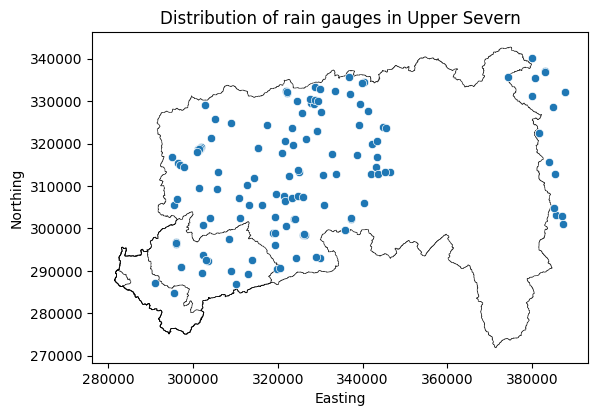

In [75]:
fig, ax = plt.subplots(1)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
abermule_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
bewdley_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
dolwen_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
plynlimon_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
sns.scatterplot(x="EASTING", y="NORTHING", data=severn_rain_gauge_metadata.filter(pl.col("ID").is_in(reliable_gauge_ids)))
ax.set_title("Distribution of rain gauges in Upper Severn")

# 3. Compare gridded rainfall product (CEH-GEAR) with rain gauge data
Okay, now we can start running some analysis.


## 3.1 Join one gauge to one grid cell

In [28]:
CHOSEN_GAUGE_ID = 90358

In [29]:
one_gauge = severn_rain_gauge_data_filtered.filter(pl.col("ID") == CHOSEN_GAUGE_ID)
one_gauge_metadata = severn_rain_gauge_metadata.filter(pl.col("ID") == CHOSEN_GAUGE_ID)
one_gauge_completeness = severn_rain_gauge_data_completeness.filter(pl.col("ID") == CHOSEN_GAUGE_ID)

In [36]:
one_gauge_metadata

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
90358,2918,"""SUGNALL HALL""","""GB-GBN""",379831,331185,28,143,"""/BI/UK/GB/ENG/STS/"""


We can use the `method='nearest'` argument to get the nearest grid cell

In [31]:
# spatial subset
one_gauge_grid_cell = severn_gear_daily.sel(
    x=one_gauge_metadata['EASTING'],
    y=one_gauge_metadata['NORTHING'],
    method='nearest')

# time subset
one_gauge_grid_cell = one_gauge_grid_cell.sel(
    time=slice(one_gauge_completeness['start_date'].item(),
               one_gauge_completeness['end_date'].item()))


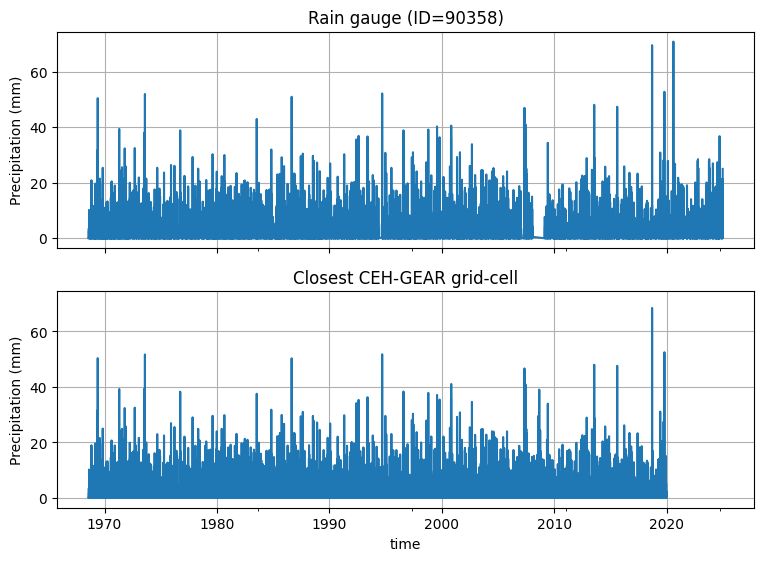

In [37]:
# plot both time series on the same y-axis
fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True, sharey=True)

one_gauge.to_pandas().set_index("DATETIME")["PRECIPITATION"].plot(ax=axes[0])
one_gauge_grid_cell['rainfall_amount'].plot(ax=axes[1])

axes[0].set_title(f"Rain gauge (ID={CHOSEN_GAUGE_ID})")
axes[1].set_title("Closest CEH-GEAR grid-cell")

for ax in axes:
    ax.grid()
    ax.set_ylabel("Precipitation (mm)")

Let's more directly compare the two...

In [38]:
one_gridcell_rainfall_amount = one_gauge_grid_cell['rainfall_amount'].data.flatten()
one_gridcell_time = one_gauge_grid_cell['time'].data.flatten()

In [39]:
one_gauge_grid_cell_df = pl.DataFrame({
        "DATETIME": one_gridcell_time,
        "PRECIPITATION_GRID": one_gridcell_rainfall_amount
    })
one_gauge_grid_cell_df = one_gauge_grid_cell_df.with_columns(pl.col("DATETIME").cast(pl.Datetime("us")))

In [40]:
one_gauge_joined = one_gauge.join(one_gauge_grid_cell_df, on="DATETIME", how='left')
one_gauge_joined.head()

ID,DATETIME,PRECIPITATION,PRECIPITATION_GRID
i64,datetime[μs],f64,f64
90358,1968-08-01 00:00:00,0.0,0.0
90358,1968-08-02 00:00:00,0.0,0.0
90358,1968-08-03 00:00:00,0.0,0.0
90358,1968-08-04 00:00:00,0.0,0.0
90358,1968-08-05 00:00:00,0.0,0.0


In [41]:
one_gauge_joined = one_gauge_joined.with_columns(
    (pl.col("PRECIPITATION") - pl.col("PRECIPITATION_GRID")).alias("rainfall_diff")
)

In [42]:
one_gauge_joined.head()

ID,DATETIME,PRECIPITATION,PRECIPITATION_GRID,rainfall_diff
i64,datetime[μs],f64,f64,f64
90358,1968-08-01 00:00:00,0.0,0.0,0.0
90358,1968-08-02 00:00:00,0.0,0.0,0.0
90358,1968-08-03 00:00:00,0.0,0.0,0.0
90358,1968-08-04 00:00:00,0.0,0.0,0.0
90358,1968-08-05 00:00:00,0.0,0.0,0.0


In [43]:
# drop null values so that we are not including values where either the CEH-GEAR or rain gauge is a missing value 
one_gauge_joined = one_gauge_joined.drop_nulls()

Text(0.5, 1.0, 'Difference between gauge 90358 & the nearest CEH-GEAR grid cell')

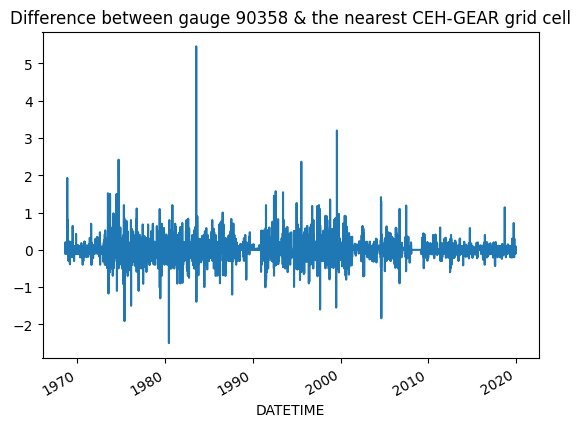

In [44]:
one_gauge_joined.to_pandas().set_index("DATETIME")['rainfall_diff'].plot()
plt.title(f"Difference between gauge {CHOSEN_GAUGE_ID} & the nearest CEH-GEAR grid cell")

In [45]:
print("mean difference =", one_gauge_joined['rainfall_diff'].mean())

mean difference = 0.004892145186900544


## 3.1.1 Look at monthly sums
To make the plot more visually appealing, we can compute the difference in rainfall based on monthly sum. this wasy, we will get less spikes 
TODO

In [46]:
# group data into monthly sum
one_gauge_monthly_sums = one_gauge_joined.group_by_dynamic("DATETIME", every="1mo").agg(
    [
    pl.col("PRECIPITATION").sum(),
    pl.col("PRECIPITATION_GRID").sum()
    ]
)

In [47]:
one_gauge_monthly_sums = one_gauge_monthly_sums.with_columns(
    (pl.col("PRECIPITATION") - pl.col("PRECIPITATION_GRID")).alias("rainfall_diff")
)

In [48]:
one_gauge_monthly_sums.head()

DATETIME,PRECIPITATION,PRECIPITATION_GRID,rainfall_diff
datetime[μs],f64,f64,f64
1968-08-01 00:00:00,42.9,42.7,0.2
1968-09-01 00:00:00,85.5,85.3,0.2
1968-10-01 00:00:00,56.5,56.1,0.4
1968-11-01 00:00:00,54.5,49.675941,4.824059
1968-12-01 00:00:00,38.3,38.6,-0.3


#### 🤨 Task: What is the mean monthly difference?
Replace the ??? below with your answer

In [200]:
one_gauge_monthly_sums["rainfall_diff"].???

SyntaxError: invalid syntax (965914466.py, line 1)

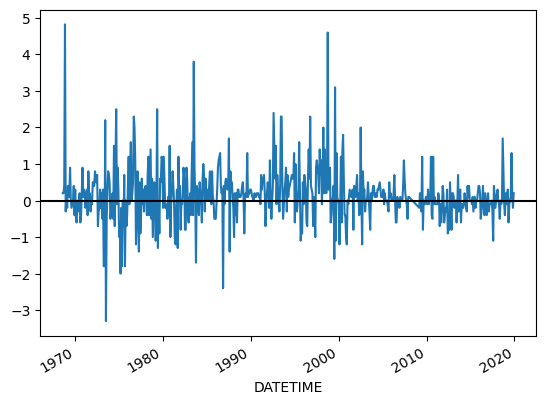

In [49]:
one_gauge_monthly_sums.to_pandas().set_index("DATETIME")['rainfall_diff'].plot()
plt.axhline(color='k')

#### ❓ Question: Is the nearest CEH-GEAR grid cell over or underestimating rainfall relative to the rain gauge? 

Answer: ???

#### 🤨 Task: Change the resolution of the time group_by below to:
1. 6 months
2. 1 year
3. Resolution of your chosing

Replace the ??? below with your answer

*Hint: find out online the correct syntax to group every 6 months and 1 year*
   

In [ ]:
one_gauge_joined.group_by_dynamic("DATETIME", every=???).agg(
    [
    pl.col("PRECIPITATION").sum(),
    pl.col("PRECIPITATION_GRID").sum()
    ]
)

??? = ???.with_columns(
    (pl.col("PRECIPITATION") - pl.col("PRECIPITATION_GRID")).alias("rainfall_diff")
)

???.to_pandas().set_index("DATETIME")['rainfall_diff'].plot()
plt.axhline(color='k')

#### 🤨 Task: Before moving on, go back to 3.1 and replace CHOSEN_GAUGE_ID with a new ID, then re-run all cells in 3.1

## 3.2 Repeating for multiple rain gauges
A lot of data research involves trial and error and repetition. It is always a good idea to get something working with a small subset before scaling up and applying your analysis to an entire dataset. In our case, we have code to compute a simple difference between a rain gauge and its nearest CEH-GEAR grid cell. Now let's scale that up to look at the entire catchment...

> In this section, we bring everything together, and scale up our research code   

Below are some functions with relatively descriptive names that will carry out all the analysis we saw in section 3.1.
In writing these, we have tried to stick to the Single Responsibility Principle as best we can (that is, one function does one thing)

In [50]:
def calc_mean_diff_between_rain_gauge_and_nearest_grid_cell(gauge_id):
    """
    Calculate mean difference between a given rain gauge and the nearest CEH-GEAR grid cell
    """
    # 1. Load in gauge data and related metadata
    one_gauge = severn_rain_gauge_data_filtered.filter(pl.col("ID") == gauge_id)
    one_gauge_metadata = severn_rain_gauge_metadata.filter(pl.col("ID") == gauge_id)
    one_gauge_completeness = severn_rain_gauge_data_completeness.filter(pl.col("ID") == gauge_id)
    
    # 2. Get nearest CEH-GEAR grid cell 
    one_gauge_grid_cell = get_nearest_gear_data_by_coords(easting=one_gauge_metadata['EASTING'], northing=one_gauge_metadata['NORTHING'])

    # 3. Subset nearest grid cell data by start end date of gauge
    one_gauge_grid_cell = subset_gear_data_by_gauge_start_end_date(
        gear_data=one_gauge_grid_cell,
        start_date=one_gauge_completeness['start_date'].item(), 
        end_date=one_gauge_completeness['end_date'].item()
    )

    # 4. Convert data into polars format
    one_gauge_grid_cell_df = convert_gear_data_to_polars_df(one_gauge_grid_cell)

    # 5. Join to rain gauge data
    one_gauge_joined = one_gauge.join(one_gauge_grid_cell_df, on="DATETIME", how='left')

    # 6. Calculate daily rainfall differences
    one_gauge_joined = calculate_rainfall_difference(one_gauge_joined)
    return one_gauge_joined


def get_nearest_gear_data_by_coords(easting, northing):
    return severn_gear_daily.sel(
            x=easting,
            y=northing,
            method='nearest')


def subset_gear_data_by_gauge_start_end_date(gear_data, start_date, end_date):
    return gear_data.sel(time=slice(start_date, end_date))


def convert_gear_data_to_polars_df(gear_data):
    gear_data_rainfall_amount = gear_data['rainfall_amount'].data.flatten()
    gear_data_time = gear_data['time'].data.flatten()
    
    gear_data_df = pl.DataFrame({
            "DATETIME": gear_data_time,
            "PRECIPITATION_GRID": gear_data_rainfall_amount
        })
    gear_data_df = gear_data_df.with_columns(pl.col("DATETIME").cast(pl.Datetime("us")))
    return gear_data_df


def calculate_rainfall_difference(one_gauge_joined):
    one_gauge_joined = one_gauge_joined.with_columns(
            (pl.col("PRECIPITATION") - pl.col("PRECIPITATION_GRID")).alias("rainfall_diff")
        )
    one_gauge_joined = one_gauge_joined.drop_nulls()
    return one_gauge_joined

In [51]:
CHOSEN_GAUGE_ID = 90358

In [52]:
calc_mean_diff_between_rain_gauge_and_nearest_grid_cell(gauge_id=CHOSEN_GAUGE_ID)

ID,DATETIME,PRECIPITATION,PRECIPITATION_GRID,rainfall_diff
i64,datetime[μs],f64,f64,f64
90358,1968-08-01 00:00:00,0.0,0.0,0.0
90358,1968-08-02 00:00:00,0.0,0.0,0.0
90358,1968-08-03 00:00:00,0.0,0.0,0.0
90358,1968-08-04 00:00:00,0.0,0.0,0.0
90358,1968-08-05 00:00:00,0.0,0.0,0.0
…,…,…,…,…
90358,2019-12-27 00:00:00,0.0,0.0,0.0
90358,2019-12-28 00:00:00,0.0,0.0,0.0
90358,2019-12-29 00:00:00,0.0,0.0,0.0


Now, we can loop through each gauge and compute some statistics

In [53]:
all_unique_gauge_ids = severn_rain_gauge_data_filtered['ID'].unique()
all_unique_gauge_ids

ID
i64
90358
90492
90537
90589
90590
…
429744
429745
429808


In [54]:
%%time
# takes around 30 seconds

# Store all statistics in a dictionary
all_gauge_comparisons = []

for gauge_id in all_unique_gauge_ids:
    gauge_comparison = {}
    one_gauge_rainfall_diff = calc_mean_diff_between_rain_gauge_and_nearest_grid_cell(gauge_id=gauge_id)
    gauge_comparison["gauge_id"] = gauge_id
    gauge_comparison["stdev_diff"] = one_gauge_rainfall_diff['rainfall_diff'].mean()
    gauge_comparison["mean_diff"] = one_gauge_rainfall_diff['rainfall_diff'].std()
    gauge_comparison["max_diff"] = one_gauge_rainfall_diff['rainfall_diff'].max()
    gauge_comparison["min_diff"] = one_gauge_rainfall_diff['rainfall_diff'].min()
    all_gauge_comparisons.append(gauge_comparison)

CPU times: user 814 ms, sys: 154 ms, total: 968 ms
Wall time: 1.8 s


In [56]:
all_gauge_comparisons_df = pl.from_dicts(all_gauge_comparisons)
all_gauge_comparisons_df

gauge_id,stdev_diff,mean_diff,max_diff,min_diff
i64,f64,f64,f64,f64
90358,0.004892,0.145097,5.45697,-2.5
90492,-0.003807,0.183893,3.323217,-3.911053
90537,0.005037,0.211796,5.297568,-2.5
90589,0.000582,0.043491,0.6,-0.6
90590,-0.005441,0.120594,2.0,-3.692674
…,…,…,…,…
429744,0.019953,0.166522,3.0,-5.7
429745,0.016247,0.063594,1.159451,-1.34148
429808,-0.002407,0.202297,2.761133,-1.1305


Text(50.722222222222214, 0.5, 'Gauge no.')

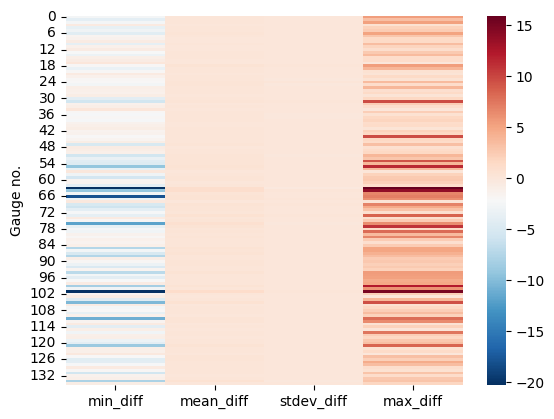

In [66]:
cols_to_plot = ["min_diff", "mean_diff", "stdev_diff",  "max_diff"]
fig, ax = plt.subplots(1)
sns.heatmap(all_gauge_comparisons_df.select(cols_to_plot), cmap='RdBu_r', ax=ax)
ax.set_xticklabels(cols_to_plot)
ax.set_ylabel("Gauge no.")

In [73]:
all_gauge_comparisons_df

gauge_id,stdev_diff,mean_diff,max_diff,min_diff
i64,f64,f64,f64,f64
90358,0.004892,0.145097,5.45697,-2.5
90492,-0.003807,0.183893,3.323217,-3.911053
90537,0.005037,0.211796,5.297568,-2.5
90589,0.000582,0.043491,0.6,-0.6
90590,-0.005441,0.120594,2.0,-3.692674
…,…,…,…,…
429744,0.019953,0.166522,3.0,-5.7
429745,0.016247,0.063594,1.159451,-1.34148
429808,-0.002407,0.202297,2.761133,-1.1305


Of course, mean and standard deviation are relatively simple summary statistics, but you can imagine we can run more advanced statistics just as easily in this structure

Text(0.5, 0, 'Maximum difference')

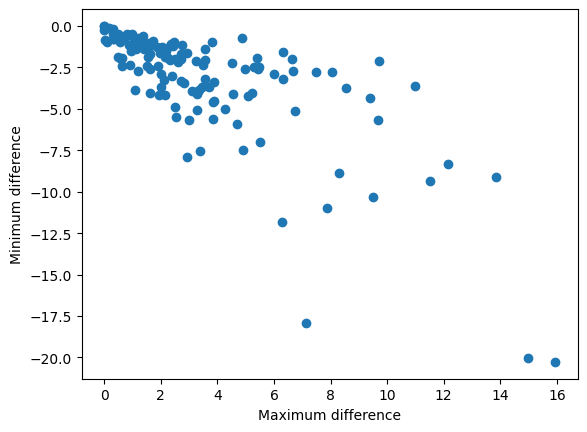

In [255]:
fig, ax = plt.subplots(1)
ax.scatter(all_gauge_comparisons_df['max_diff'], all_gauge_comparisons_df['min_diff'])
ax.set_ylabel("Minimum difference")
ax.set_xlabel("Maximum difference")

Let's join this data back to the metadata so we can plot the gauges on a map

In [268]:
severn_rain_gauge_metadata_w_comparison = severn_rain_gauge_metadata.join(all_gauge_comparisons_df, left_on='ID', right_on='gauge_id')

In [269]:
severn_rain_gauge_metadata_w_comparison.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH,stdev_diff,mean_diff,max_diff,min_diff
i64,i64,str,str,i64,i64,i64,i64,str,f64,f64,f64,f64
90358,2918,"""SUGNALL HALL""","""GB-GBN""",379831,331185,28,143,"""/BI/UK/GB/ENG/STS/""",0.004892,0.145097,5.45697,-2.5
90492,2920,"""WALTON HALL GARDENS""","""GB-GBN""",384900,328500,28,99,"""/BI/UK/GB/ENG/STS/""",-0.003807,0.183893,3.323217,-3.911053
90537,2921,"""WHITMORE P STA""","""GB-GBN""",379900,340100,28,121,"""/BI/UK/GB/ENG/CHS/""",0.005037,0.211796,5.297568,-2.5
90589,2922,"""HATTON W WKS""","""GB-GBN""",382900,337000,28,108,"""/BI/UK/GB/ENG/STS/""",0.000582,0.043491,0.6,-0.6
90590,2923,"""HATTON W WKS NO 2""","""GB-GBN""",382900,336900,28,108,"""/BI/UK/GB/ENG/STS/""",-0.005441,0.120594,2.0,-3.692674


<Axes: xlabel='Easting', ylabel='Northing'>

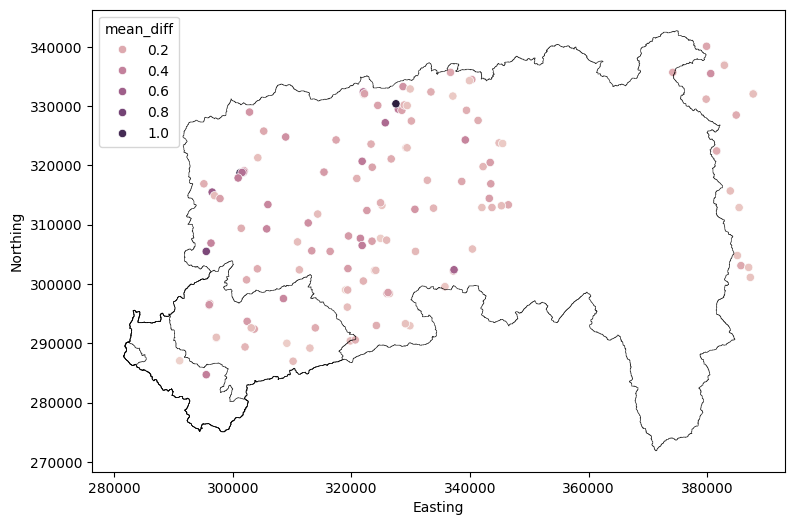

In [270]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
sns.scatterplot(x="EASTING", y="NORTHING", hue="mean_diff", data=severn_rain_gauge_metadata_w_comparison, ax=ax)
abermule_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
bewdley_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
dolwen_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
plynlimon_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)

## 3.3 Compute catchment averages and compare
As shown in the above plot, the rain gauge network is particularly patchy. In this final example, we will compute catchment average rainfall.

In [68]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * data_utils.binarize_hght_clip(region_mask).data

In [69]:
abermule_hght = data_utils.make_region_hght_clip(abermule_shp, hght_data=severn_hght)
dolwen_hght = data_utils.make_region_hght_clip(dolwen_shp, hght_data=severn_hght)
plynlimon_hght = data_utils.make_region_hght_clip(plynlimon_shp, hght_data=severn_hght)



In [42]:
%%time
region_mask_rainfall = mask_region_rainfall(severn_gear_daily, abermule_hght)

CPU times: user 5.91 s, sys: 1.22 s, total: 7.13 s
Wall time: 7.77 s


(270000.0, 310000.0)

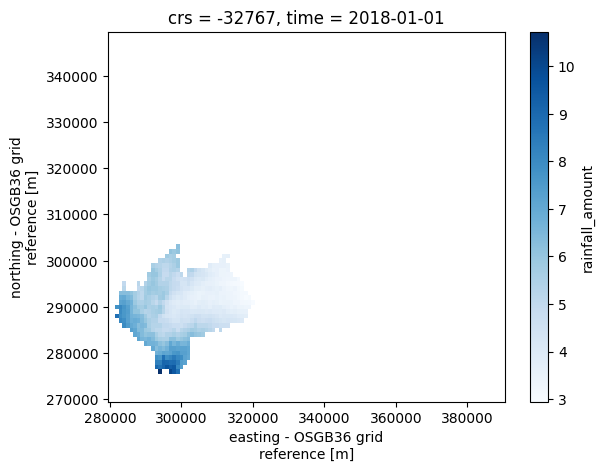

In [53]:
region_mask_rainfall.sel(time="2018-01-01")["rainfall_amount"].plot(cmap='Blues')
ax.set_xlim(280000, 330000); ax.set_ylim(270000, 310000)

In [49]:
%%time
region_mask_rainfall_mean = region_mask_rainfall.mean("time")

CPU times: user 834 ms, sys: 12.4 s, total: 13.2 s
Wall time: 20.1 s


CPU times: user 13.2 ms, sys: 3.87 ms, total: 17 ms
Wall time: 21.7 ms


(270000.0, 310000.0)

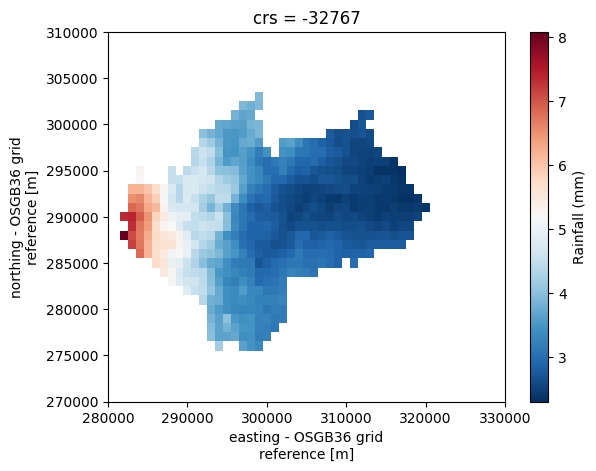

In [51]:
%%time
# takes 20 seconds
fig, ax = plt.subplots(1)
region_mask_rainfall_mean['rainfall_amount'].plot(ax=ax, cmap='RdBu_r', cbar_kwargs={'label': 'Rainfall (mm)'})
ax.set_xlim(280000, 330000); ax.set_ylim(270000, 310000)

In [70]:
catchments_shp_and_hght = {'Abermule': {'shp': abermule_shp, 'hght': abermule_hght}, \
    'Dolwen': {'shp': dolwen_shp, 'hght': dolwen_hght},\
    'Plynlimon Flume': {'shp': plynlimon_shp, 'hght': plynlimon_hght}}

(270000.0, 310000.0)

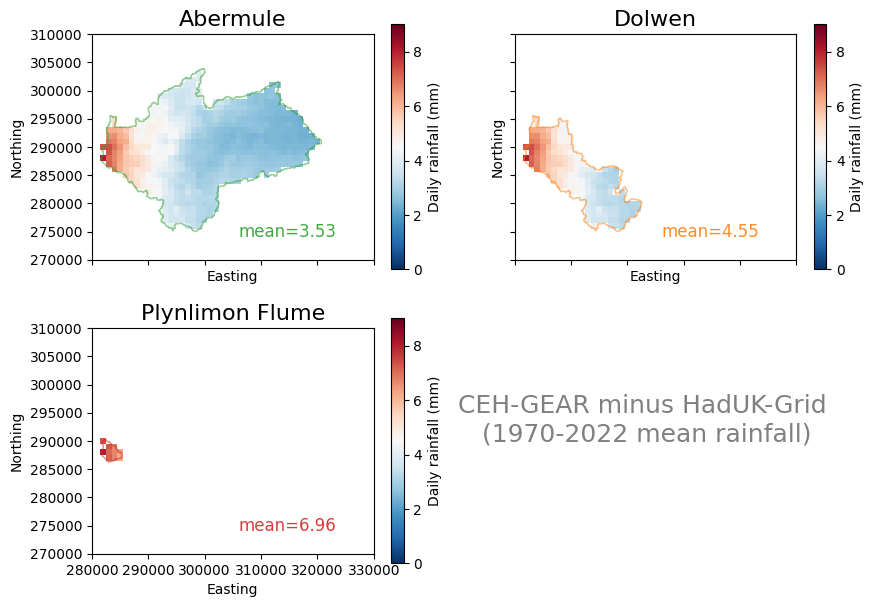

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

for ax, catchment, color_to_use in zip(axes.flatten(), catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
    region_mask_rain_diff = mask_region_rainfall(severn_gear_daily, catchments_shp_and_hght[catchment]['hght']).mean('time')["rainfall_amount"]
    region_mask_rain_diff.plot(ax=ax, vmin=0, vmax=9, cmap='RdBu_r', cbar_kwargs={'label': 'Daily rainfall (mm)'})
    catchments_shp_and_hght[catchment]['shp'].plot(ax=ax, facecolor='none', edgecolor=color_to_use, alpha=.5)
    ax.set_title(f"{catchment}", size=16)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.text(s=f'mean={region_mask_rain_diff.mean():.2f}', x=306000, y=274000, size=12, color=color_to_use, alpha=.9)
axes[1][1].remove()
axes[1][0].text(s='CEH-GEAR minus HadUK-Grid\n   (1970-2022 mean rainfall)', x=345000, y=290000, size=18, color='grey')
ax.set_xlim(280000, 330000); ax.set_ylim(270000, 310000)
# fig.savefig('../figures/ceh_vs_haduk_differences/catchment_mask_vs_boundary.png', bbox_inches='tight', dpi=200)



In [54]:
severn_rain_gauge_metadata_w_comparison

NameError: name 'severn_rain_gauge_metadata_w_comparison' is not defined

In [ ]:
compare different time slices?

## ❗❗ FURTHER TASKS ❗❗  
Feel free to stop at this point, but below are some additional and more advanced topics and tasks requiring more of your own input. We will provide help.

Task 1. Trends through time, and difference in estimates through time
Task 2. Use CHESS-SCAPE data  
Task 3. How does this effect estimates of floods?  


## Additional Task 1. Case Study: Examining unseen rain gauge data
Unseen rain gauge at Carreg Wen near Plynlimon 

In [16]:
carreg_daily_new = pl.read_csv(
    "s3://rain-gauge/carreg_wen_daily_rainfall.csv",
    storage_options={"endpoint_url": "https://fdri-o.s3-ext.jc.rl.ac.uk", "anon": True},
    try_parse_dates=True,
)
carreg_daily_new.head()

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
420649,1976-01-03 09:00:00,0.5
420649,1976-01-04 09:00:00,62.0
420649,1976-01-05 09:00:00,12.5
420649,1976-01-06 09:00:00,5.0
420649,1976-01-07 09:00:00,3.5


NameError: name 'all_gauge_comparisons_df' is not defined

#### 🤨 Tasks

???
Replace the ??? below with your answer

## Extra task: How does uncertainty about gridded products affect estimations of flood events

In [17]:
## Here are the dates for some high-flow event in the Upper River Severn
high_flow_dates = ["XXXX-XX-XX", ...]

## Extra task: using CHESS-SCAPE climate projection data for precipitation and temperature

In [ ]:
# We are accessing TASMAX & PRCPT for the Ensemble member #01 from the catalogue
fs = fsspec.filesystem(
    "s3",
    asynchronous=True,
    anon=True,
    endpoint_url="https://chess-scape-o.s3-ext.jc.rl.ac.uk",
)
tmax_zstore = zarr.storage.FsspecStore(
    fs, path="ens01-year100kmchunk/tmax_01_year100km.zarr"
)
pr_zstore = zarr.storage.FsspecStore(
    fs, path="ens01-year100kmchunk/pr_01_year100km.zarr"
)

chess_tmax = xr.open_zarr(
    tmax_zstore, decode_times=True, decode_cf=True, consolidated=False
)
chess_pr = xr.open_zarr(
    pr_zstore, decode_times=True, decode_cf=True, consolidated=False
)

# Additional Reading

- <https://github.com/NERC-CEH/FDRI-comparing-rainfall-data-in-upper-severn/tree/main>  

- <https://github.com/NERC-CEH/FDRI-high-altitude-rainfall-and-floods>

In [4]:
carreg_gauge_wide_neighbours.nearby_ceh

<xarray.Dataset> Size: 30GB
Dimensions:          (time: 47481, y: 200, x: 200)
Coordinates:
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 2kB 2.8e+05 2.81e+05 ... 4.78e+05 4.79e+05
  * y                (y) float64 2kB 2.41e+05 2.42e+05 ... 4.39e+05 4.4e+05
Data variables:
    min_dist         (time, y, x) float64 15GB dask.array<chunksize=(365, 47, 20), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 15GB dask.array<chunksize=(365, 47, 20), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In [5]:
carreg_w_nearby["rain_mm_nearby_ceh"].drop_nulls()

rain_mm_nearby_ceh
f64
0.014805
0.0
1.698439
5.994592
1.117035
…
0.118583
0.010325
0.031908


In [6]:
carreg_w_nearby["rain_mm"].drop_nulls()

rain_mm
f64
2.0
5.1
1.5
0.0
10.9
…
7.3
0.1
0.0
